# 14.1b: Bulk vs Thermal Motion - SGD vs Adam

**Decomposing total kinetic energy into coherent drift vs random thermal motion.**

Extends 14.1a by separating:
- **Bulk motion**: Centroid displacement (coherent drift of the entire cloud)
- **Thermal motion**: Peculiar velocities (motion relative to the centroid)

**Key insight:** The "effective temperature" in 14.1a measures *total* kinetic energy. But if all tokens move together (bulk flow), the system can have high velocity but zero thermal energy.

$$T_{\text{total}} = T_{\text{bulk}} + T_{\text{thermal}}$$

## Parameters

In [1]:
# Data sources
SGD_DATA_PATH = "../tensors/Lil_Gatsby/13.1a_training_data.safetensors"
ADAM_DATA_PATH = "../tensors/Lil_Gatsby/13.1b_training_data.safetensors"

# Analysis parameters
MAX_STEPS_TO_PLOT = 2000  # Focus on early dynamics

# Visualization
DPI = 200

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import safe_open

np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [3]:
def load_training_data(path):
    """Load embeddings, token IDs, and convert to float32."""
    with safe_open(path, framework='pt', device='cpu') as f:
        embeddings_bf16 = f.get_tensor('embeddings')
        recorded_steps = f.get_tensor('recorded_steps')
        dead_token_ids = f.get_tensor('dead_token_ids')
        live_token_ids = f.get_tensor('live_token_ids')
    
    # Convert to float32 for analysis
    embeddings = embeddings_bf16.to(torch.float32)
    
    return embeddings, recorded_steps, dead_token_ids, live_token_ids

print("Loading SGD data...")
sgd_emb, sgd_steps, dead_ids, live_ids = load_training_data(SGD_DATA_PATH)
print(f"  SGD: {sgd_emb.shape}")

print("\nLoading Adam data...")
adam_emb, adam_steps, _, _ = load_training_data(ADAM_DATA_PATH)
print(f"  Adam: {adam_emb.shape}")

n_steps, n_tokens, n_dims = sgd_emb.shape
n_dead = len(dead_ids)
n_live = len(live_ids)

print(f"\n✓ Data loaded")
print(f"  Dead tokens: {n_dead}")
print(f"  Live tokens: {n_live}")

Loading SGD data...
  SGD: torch.Size([10001, 128, 64])

Loading Adam data...
  Adam: torch.Size([10001, 128, 64])

✓ Data loaded
  Dead tokens: 50
  Live tokens: 78


## Compute Centroid Trajectories

The centroid trajectory tells us how the "center of mass" of the token cloud moves over time.

In [4]:
def compute_centroids(embeddings):
    """
    Compute centroid at each timestep.
    
    Returns:
        centroids: [n_steps, n_dims] array
    """
    centroids = embeddings.mean(dim=1)  # Average over tokens
    return centroids

print("Computing centroids...")
sgd_centroids = compute_centroids(sgd_emb)
adam_centroids = compute_centroids(adam_emb)

print(f"\n✓ Centroids computed")
print(f"  SGD centroid displacement: {torch.norm(sgd_centroids[-1] - sgd_centroids[0]).item():.6f}")
print(f"  Adam centroid displacement: {torch.norm(adam_centroids[-1] - adam_centroids[0]).item():.6f}")

Computing centroids...

✓ Centroids computed
  SGD centroid displacement: 0.150027
  Adam centroid displacement: 0.320773


## Decompose Motion: Lab Frame → Bulk Rest Frame

**Lab frame velocities:** 
$$\mathbf{v}_i^{\text{lab}}(t) = \mathbf{x}_i(t+1) - \mathbf{x}_i(t)$$

**Bulk velocity:**
$$\mathbf{v}_{\text{bulk}}(t) = \langle \mathbf{v}_i^{\text{lab}}(t) \rangle_i = \mathbf{c}(t+1) - \mathbf{c}(t)$$

**Peculiar velocities (thermal motion):**
$$\mathbf{v}_i^{\text{pec}}(t) = \mathbf{v}_i^{\text{lab}}(t) - \mathbf{v}_{\text{bulk}}(t)$$

In [5]:
def decompose_motion(embeddings, centroids):
    """
    Decompose velocities into bulk and thermal components.
    
    Returns:
        v_lab: [n_steps-1, n_tokens, n_dims] lab frame velocities
        v_bulk: [n_steps-1, n_dims] bulk velocity
        v_pec: [n_steps-1, n_tokens, n_dims] peculiar velocities
    """
    # Lab frame velocities
    v_lab = embeddings[1:] - embeddings[:-1]  # [n_steps-1, n_tokens, n_dims]
    
    # Bulk velocity (centroid motion)
    v_bulk = centroids[1:] - centroids[:-1]  # [n_steps-1, n_dims]
    
    # Peculiar velocities (subtract bulk from each token)
    v_pec = v_lab - v_bulk.unsqueeze(1)  # Broadcast bulk over tokens
    
    return v_lab, v_bulk, v_pec

print("Decomposing motion for SGD...")
sgd_v_lab, sgd_v_bulk, sgd_v_pec = decompose_motion(sgd_emb, sgd_centroids)

print("Decomposing motion for Adam...")
adam_v_lab, adam_v_bulk, adam_v_pec = decompose_motion(adam_emb, adam_centroids)

print(f"\n✓ Motion decomposed")

Decomposing motion for SGD...
Decomposing motion for Adam...

✓ Motion decomposed


## Compute Temperatures

**Total temperature** (what we computed in 14.1a):
$$T_{\text{total}} = \langle |\mathbf{v}_i^{\text{lab}}|^2 \rangle_i$$

**Bulk temperature** (kinetic energy of centroid motion):
$$T_{\text{bulk}} = |\mathbf{v}_{\text{bulk}}|^2$$

**Thermal temperature** (random motion in rest frame):
$$T_{\text{thermal}} = \langle |\mathbf{v}_i^{\text{pec}}|^2 \rangle_i$$

In [6]:
def compute_temperatures(v_lab, v_bulk, v_pec):
    """
    Compute total, bulk, and thermal temperatures.
    
    Returns:
        T_total, T_bulk, T_thermal: [n_steps-1] arrays
    """
    # Total: mean squared velocity in lab frame
    T_total = (v_lab ** 2).sum(dim=2).mean(dim=1).numpy()
    
    # Bulk: squared bulk velocity
    T_bulk = (v_bulk ** 2).sum(dim=1).numpy()
    
    # Thermal: mean squared peculiar velocity
    T_thermal = (v_pec ** 2).sum(dim=2).mean(dim=1).numpy()
    
    return T_total, T_bulk, T_thermal

print("Computing temperatures for SGD...")
sgd_T_total, sgd_T_bulk, sgd_T_thermal = compute_temperatures(sgd_v_lab, sgd_v_bulk, sgd_v_pec)

print("Computing temperatures for Adam...")
adam_T_total, adam_T_bulk, adam_T_thermal = compute_temperatures(adam_v_lab, adam_v_bulk, adam_v_pec)

print(f"\n✓ Temperatures computed")
print(f"\nSGD:")
print(f"  T_total_max = {sgd_T_total.max():.8f}")
print(f"  T_bulk_max = {sgd_T_bulk.max():.8f}")
print(f"  T_thermal_max = {sgd_T_thermal.max():.8f}")
print(f"  Bulk/Total ratio = {sgd_T_bulk.max() / sgd_T_total.max():.2f}")

print(f"\nAdam:")
print(f"  T_total_max = {adam_T_total.max():.8f}")
print(f"  T_bulk_max = {adam_T_bulk.max():.8f}")
print(f"  T_thermal_max = {adam_T_thermal.max():.8f}")
print(f"  Bulk/Total ratio = {adam_T_bulk.max() / adam_T_total.max():.2f}")

Computing temperatures for SGD...
Computing temperatures for Adam...

✓ Temperatures computed

SGD:
  T_total_max = 0.00000103
  T_bulk_max = 0.00000005
  T_thermal_max = 0.00000099
  Bulk/Total ratio = 0.05

Adam:
  T_total_max = 0.00006405
  T_bulk_max = 0.00002905
  T_thermal_max = 0.00003907
  Bulk/Total ratio = 0.45


## Visualizations

### SGD: Total vs Bulk vs Thermal Temperature

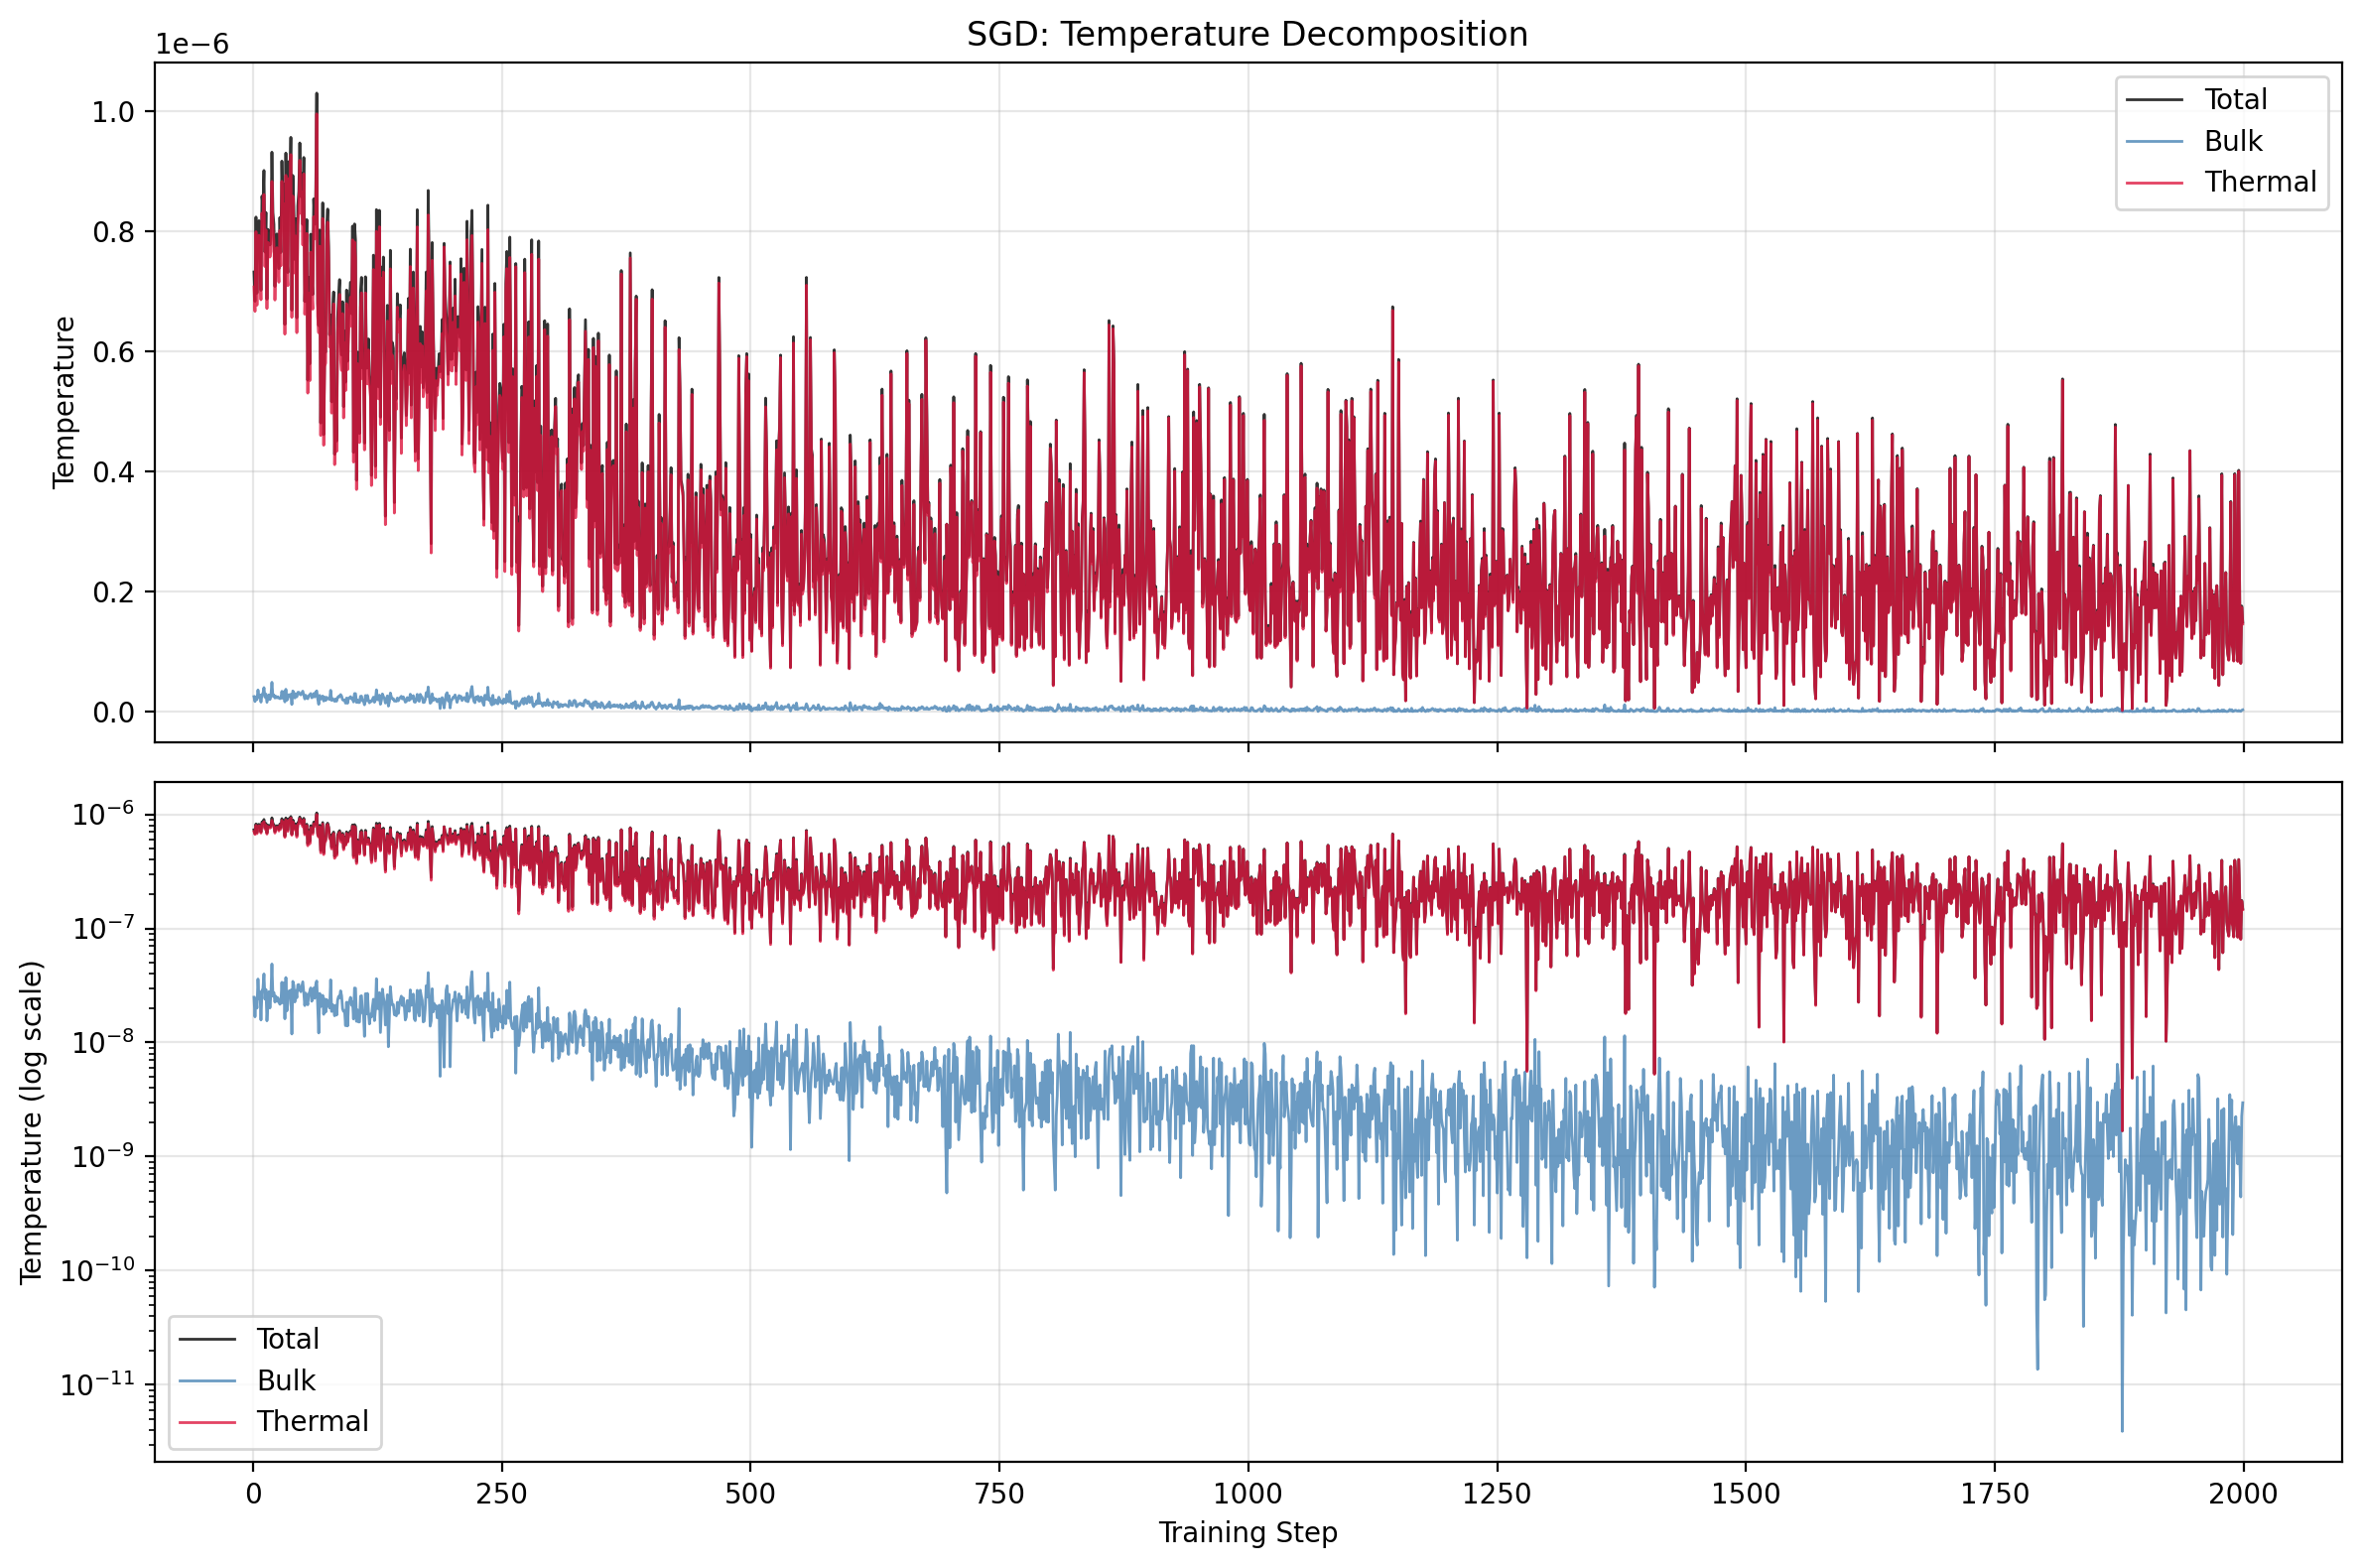

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=DPI, sharex=True)

steps = sgd_steps[1:MAX_STEPS_TO_PLOT].numpy()

# Linear scale
ax1.plot(steps, sgd_T_total[:MAX_STEPS_TO_PLOT-1], linewidth=1, color='black', 
         label='Total', alpha=0.8)
ax1.plot(steps, sgd_T_bulk[:MAX_STEPS_TO_PLOT-1], linewidth=1, color='steelblue', 
         label='Bulk', alpha=0.8)
ax1.plot(steps, sgd_T_thermal[:MAX_STEPS_TO_PLOT-1], linewidth=1, color='crimson', 
         label='Thermal', alpha=0.8)
ax1.set_ylabel('Temperature')
ax1.set_title('SGD: Temperature Decomposition')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log scale
ax2.plot(steps, sgd_T_total[:MAX_STEPS_TO_PLOT-1], linewidth=1, color='black', 
         label='Total', alpha=0.8)
ax2.plot(steps, sgd_T_bulk[:MAX_STEPS_TO_PLOT-1], linewidth=1, color='steelblue', 
         label='Bulk', alpha=0.8)
ax2.plot(steps, sgd_T_thermal[:MAX_STEPS_TO_PLOT-1], linewidth=1, color='crimson', 
         label='Thermal', alpha=0.8)
ax2.set_ylabel('Temperature (log scale)')
ax2.set_xlabel('Training Step')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Adam: Total vs Bulk vs Thermal Temperature

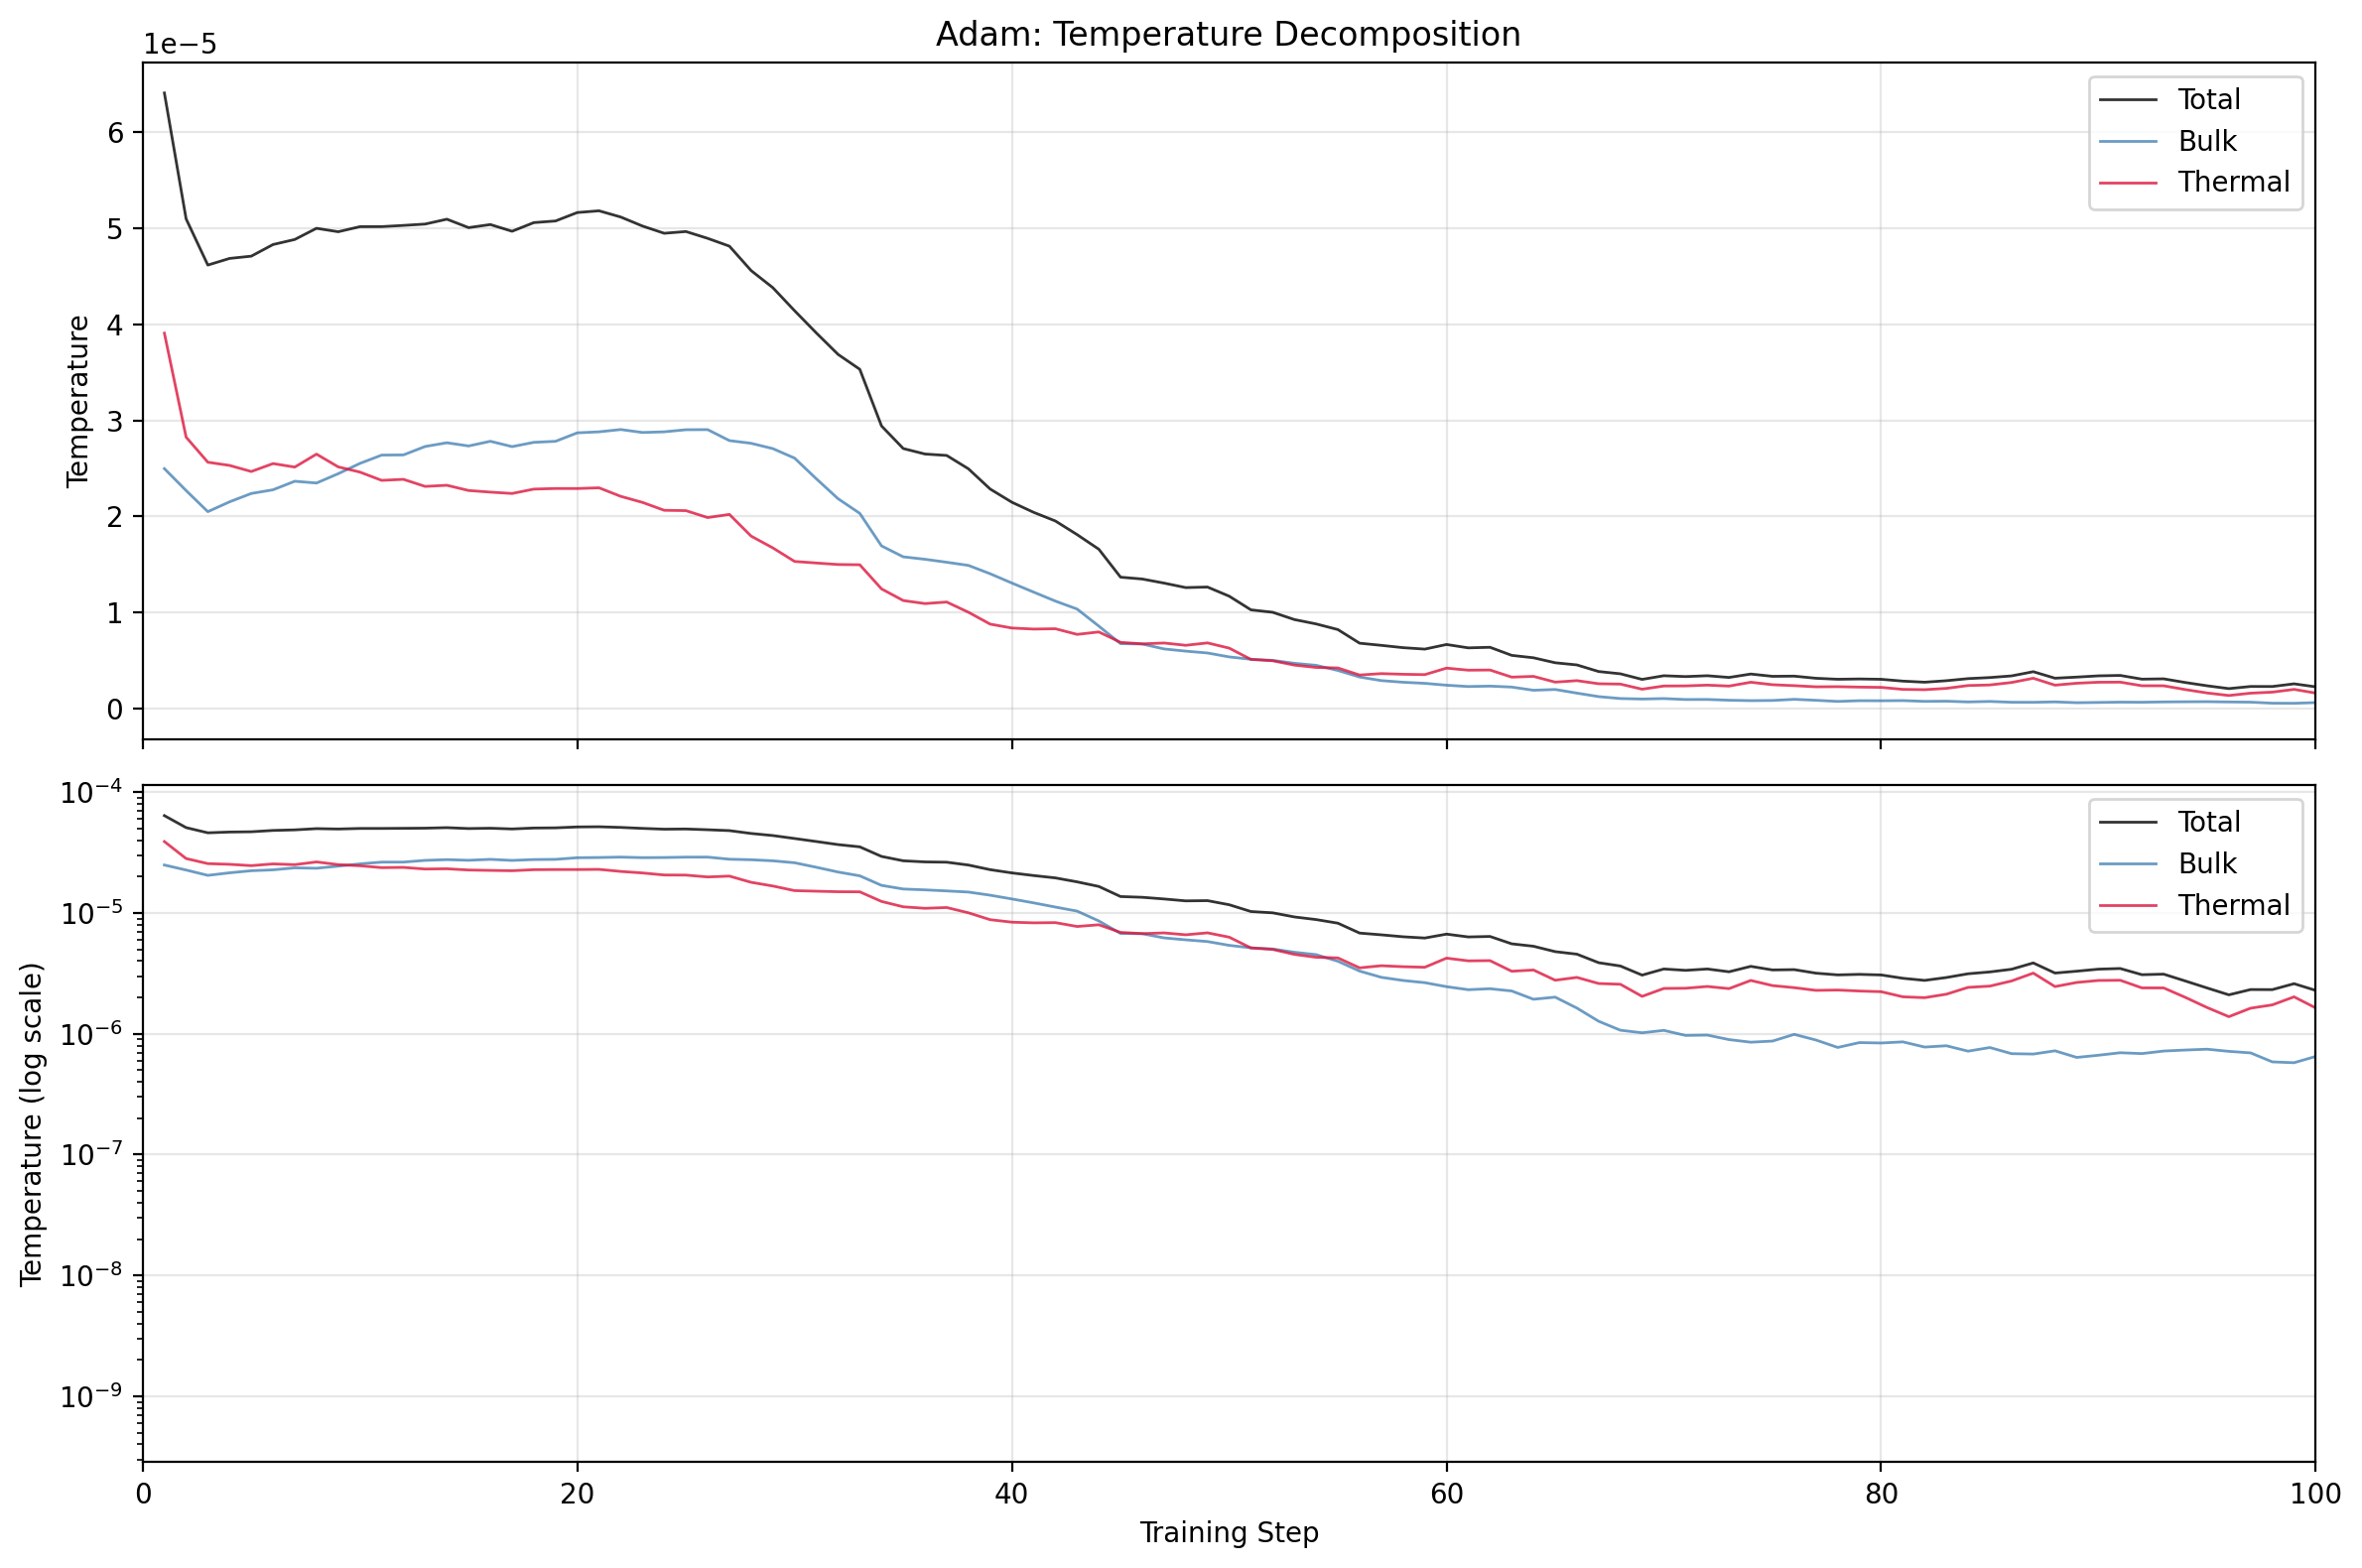

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=DPI, sharex=True)

steps = adam_steps[1:MAX_STEPS_TO_PLOT].numpy()

# Linear scale
ax1.plot(steps, adam_T_total[:MAX_STEPS_TO_PLOT-1], linewidth=1, color='black', 
         label='Total', alpha=0.8)
ax1.plot(steps, adam_T_bulk[:MAX_STEPS_TO_PLOT-1], linewidth=1, color='steelblue', 
         label='Bulk', alpha=0.8)
ax1.plot(steps, adam_T_thermal[:MAX_STEPS_TO_PLOT-1], linewidth=1, color='crimson', 
         label='Thermal', alpha=0.8)
ax1.set_ylabel('Temperature')
ax1.set_title('Adam: Temperature Decomposition')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log scale
ax2.plot(steps, adam_T_total[:MAX_STEPS_TO_PLOT-1], linewidth=1, color='black', 
         label='Total', alpha=0.8)
ax2.plot(steps, adam_T_bulk[:MAX_STEPS_TO_PLOT-1], linewidth=1, color='steelblue', 
         label='Bulk', alpha=0.8)
ax2.plot(steps, adam_T_thermal[:MAX_STEPS_TO_PLOT-1], linewidth=1, color='crimson', 
         label='Thermal', alpha=0.8)
ax2.set_ylabel('Temperature (log scale)')
ax2.set_xlabel('Training Step')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 100)
ax2.set_aspect('auto')

plt.tight_layout()
plt.show()

### Direct Comparison: Thermal Temperature Only

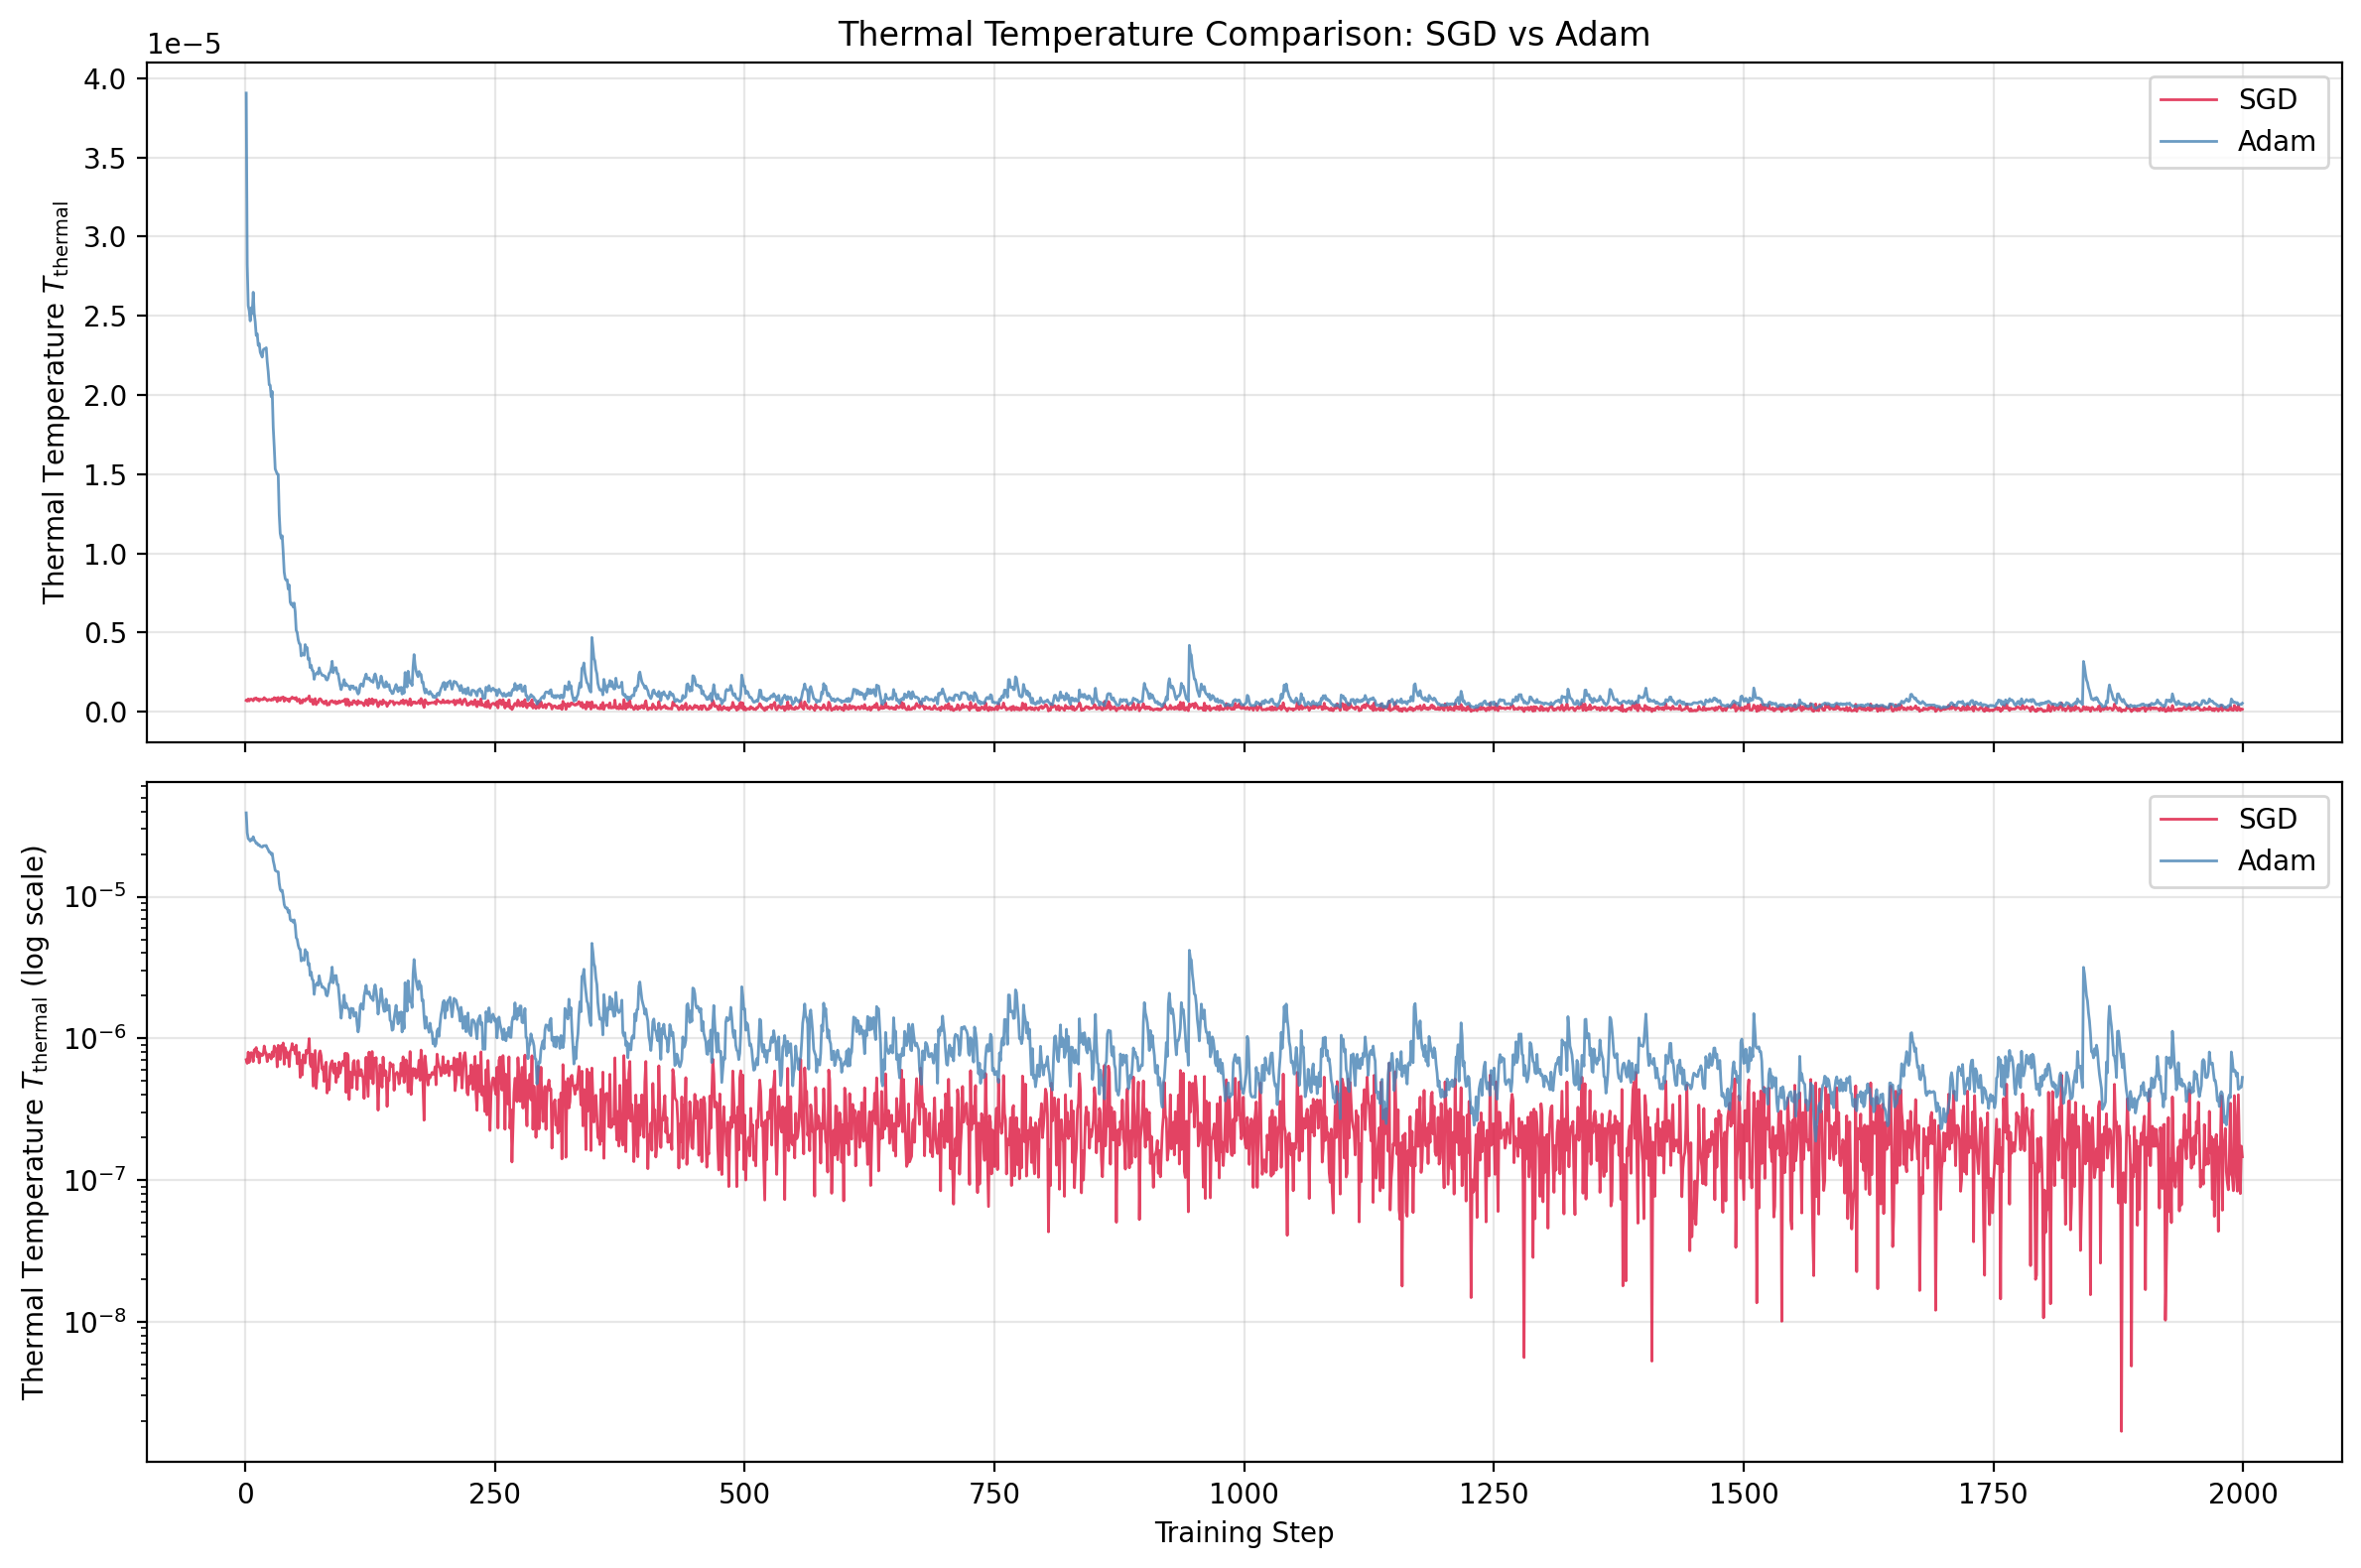

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=DPI, sharex=True)

# Linear scale
ax1.plot(sgd_steps[1:MAX_STEPS_TO_PLOT].numpy(), sgd_T_thermal[:MAX_STEPS_TO_PLOT-1], 
         linewidth=1, color='crimson', label='SGD', alpha=0.8)
ax1.plot(adam_steps[1:MAX_STEPS_TO_PLOT].numpy(), adam_T_thermal[:MAX_STEPS_TO_PLOT-1], 
         linewidth=1, color='steelblue', label='Adam', alpha=0.8)
ax1.set_ylabel('Thermal Temperature $T_{\\mathrm{thermal}}$')
ax1.set_title('Thermal Temperature Comparison: SGD vs Adam')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log scale
ax2.plot(sgd_steps[1:MAX_STEPS_TO_PLOT].numpy(), sgd_T_thermal[:MAX_STEPS_TO_PLOT-1], 
         linewidth=1, color='crimson', label='SGD', alpha=0.8)
ax2.plot(adam_steps[1:MAX_STEPS_TO_PLOT].numpy(), adam_T_thermal[:MAX_STEPS_TO_PLOT-1], 
         linewidth=1, color='steelblue', label='Adam', alpha=0.8)
ax2.set_ylabel('Thermal Temperature $T_{\\mathrm{thermal}}$ (log scale)')
ax2.set_xlabel('Training Step')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Bulk/Thermal Ratio Over Time

/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_21538/3623749485.py:4: RuntimeWarning: invalid value encountered in divide
  sgd_ratio = np.where(sgd_T_thermal > 0, sgd_T_bulk / sgd_T_thermal, 0)
/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_21538/3623749485.py:5: RuntimeWarning: invalid value encountered in divide
  adam_ratio = np.where(adam_T_thermal > 0, adam_T_bulk / adam_T_thermal, 0)


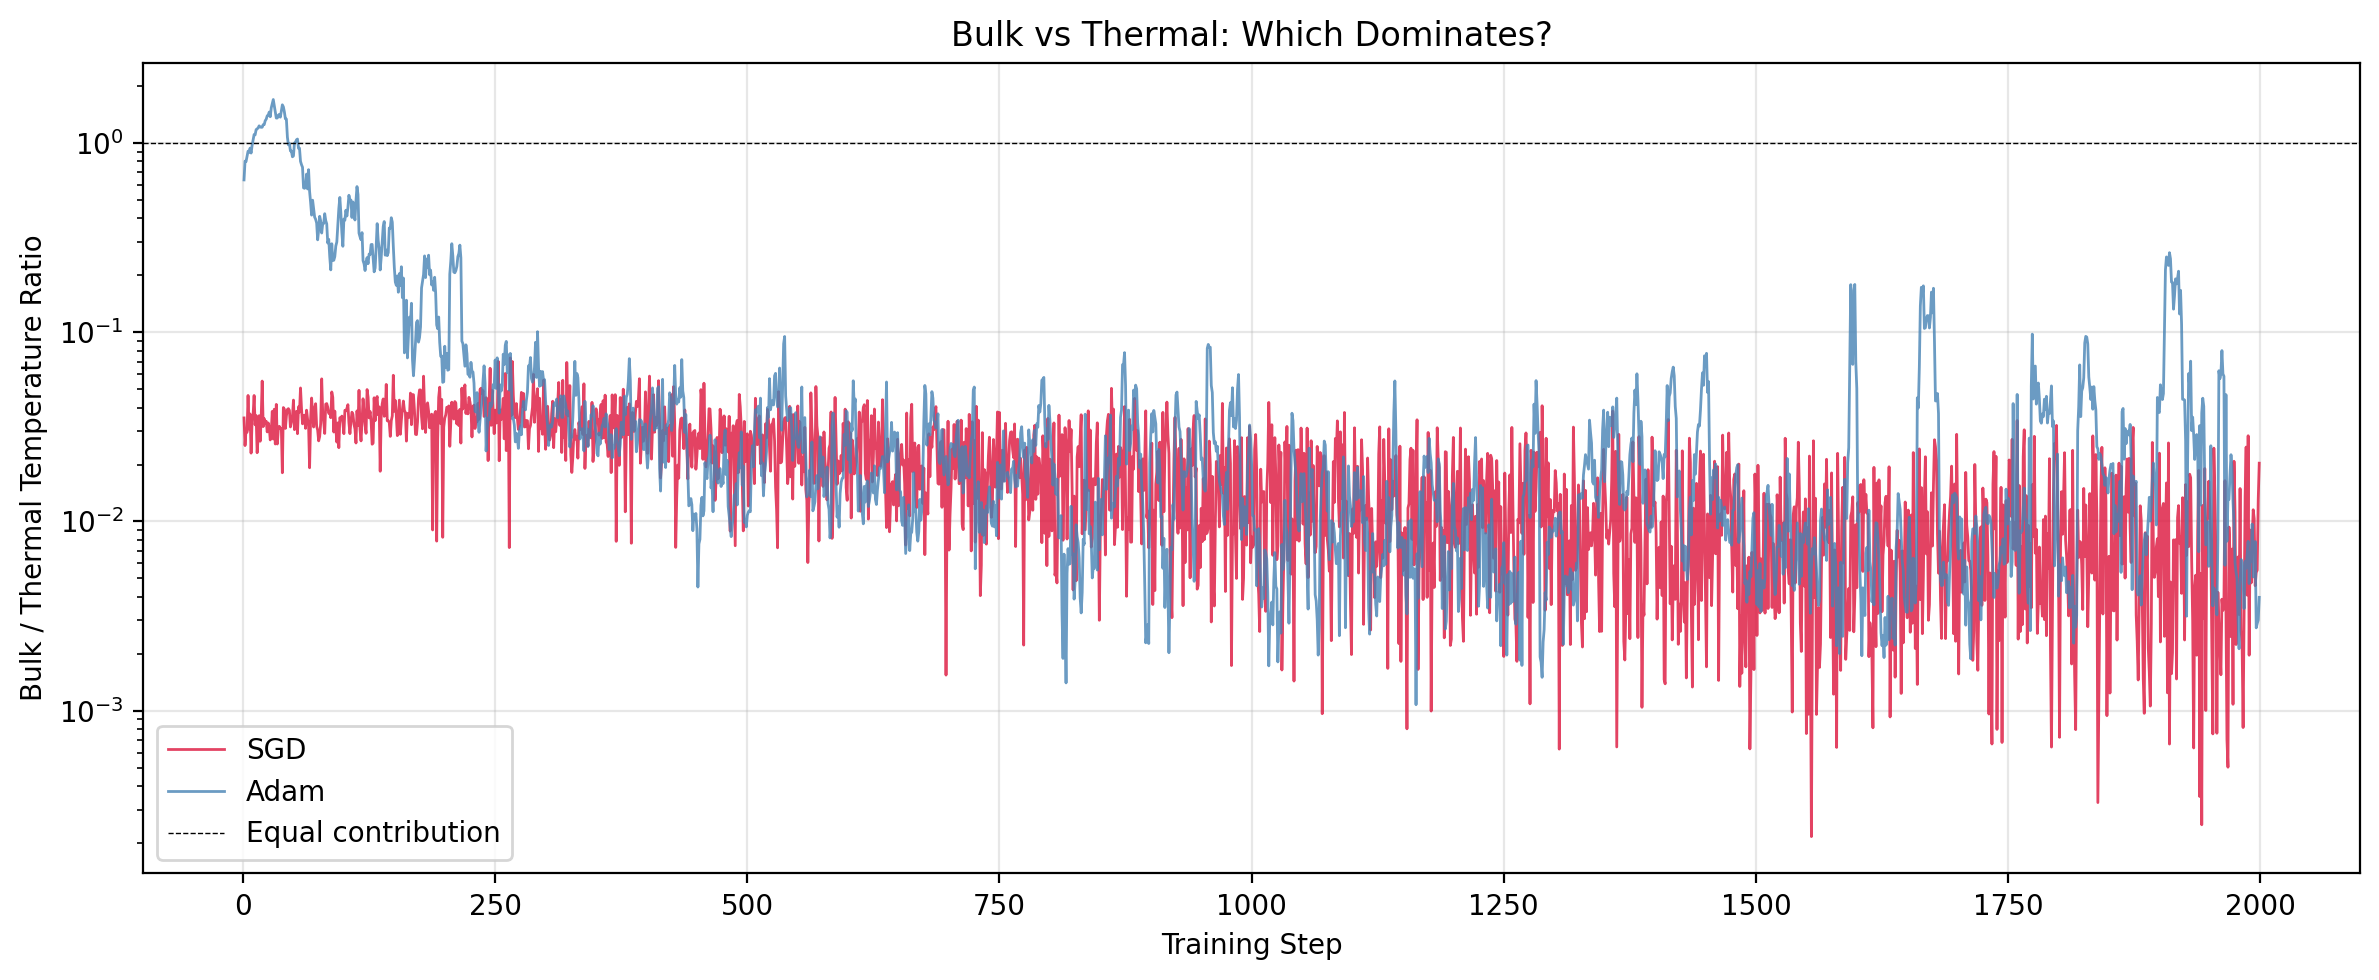


Ratio > 1: Bulk dominates (coherent drift)
Ratio < 1: Thermal dominates (random motion)


In [10]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=DPI)

# Avoid division by zero
sgd_ratio = np.where(sgd_T_thermal > 0, sgd_T_bulk / sgd_T_thermal, 0)
adam_ratio = np.where(adam_T_thermal > 0, adam_T_bulk / adam_T_thermal, 0)

ax.plot(sgd_steps[1:MAX_STEPS_TO_PLOT].numpy(), sgd_ratio[:MAX_STEPS_TO_PLOT-1], 
        linewidth=1, color='crimson', label='SGD', alpha=0.8)
ax.plot(adam_steps[1:MAX_STEPS_TO_PLOT].numpy(), adam_ratio[:MAX_STEPS_TO_PLOT-1], 
        linewidth=1, color='steelblue', label='Adam', alpha=0.8)

ax.set_xlabel('Training Step')
ax.set_ylabel('Bulk / Thermal Temperature Ratio')
ax.set_title('Bulk vs Thermal: Which Dominates?')
ax.set_yscale('log')
ax.axhline(1, color='black', linestyle='--', linewidth=0.5, label='Equal contribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRatio > 1: Bulk dominates (coherent drift)")
print("Ratio < 1: Thermal dominates (random motion)")

## Summary Statistics

In [11]:
print(f"\n{'='*80}")
print(f"BULK VS THERMAL DECOMPOSITION")
print(f"{'='*80}\n")

print("SGD:")
print(f"  Peak total temperature: {sgd_T_total.max():.8f}")
print(f"  Peak bulk temperature: {sgd_T_bulk.max():.8f}")
print(f"  Peak thermal temperature: {sgd_T_thermal.max():.8f}")
print(f"  Bulk contribution: {100 * sgd_T_bulk.max() / sgd_T_total.max():.1f}%")
print(f"  Thermal contribution: {100 * sgd_T_thermal.max() / sgd_T_total.max():.1f}%")

print(f"\nAdam:")
print(f"  Peak total temperature: {adam_T_total.max():.8f}")
print(f"  Peak bulk temperature: {adam_T_bulk.max():.8f}")
print(f"  Peak thermal temperature: {adam_T_thermal.max():.8f}")
print(f"  Bulk contribution: {100 * adam_T_bulk.max() / adam_T_total.max():.1f}%")
print(f"  Thermal contribution: {100 * adam_T_thermal.max() / adam_T_total.max():.1f}%")

print(f"\n{'='*80}")


BULK VS THERMAL DECOMPOSITION

SGD:
  Peak total temperature: 0.00000103
  Peak bulk temperature: 0.00000005
  Peak thermal temperature: 0.00000099
  Bulk contribution: 4.7%
  Thermal contribution: 96.6%

Adam:
  Peak total temperature: 0.00006405
  Peak bulk temperature: 0.00002905
  Peak thermal temperature: 0.00003907
  Bulk contribution: 45.4%
  Thermal contribution: 61.0%



## Done

In [12]:
print("✓ Bulk vs thermal analysis complete")

✓ Bulk vs thermal analysis complete
